In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [4]:
# prepare colors for plot
colors = ['#c7eae5','#008C8D']
import matplotlib
cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
matplotlib.cm.register_cmap("dana", cmap)
phasec = sns.color_palette("dana", n_colors=27)

In [5]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [6]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_males_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]

In [7]:
# calculate distance for chronological age and pseudo age
# for age
age_data=data_all.copy()
bins=[]
kld_age=[]
u_age=[]
c_age=[]
#exp=[]
for age,_df in enumerate(age_data.groupby('age')):
    bins.extend(_df[1].index.get_level_values('age').to_numpy())
    #exp.extend(['age']*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = squareform(pdist(data_temp, metric='jensenshannon'))
    utemp = pairwise_distances(data_temp)
    ctemp = pairwise_distances(data_temp, metric = 'cosine')
    kld_age.extend(np.mean(kld_temp, axis=1))
    u_age.extend(np.mean(utemp, axis=1))
    c_age.extend(np.mean(ctemp, axis=1))

In [8]:
'''
df=pd.DataFrame()
df['bins']=bins
df['jsd']=np.append(kld_age,kld_psd)
df['exp']=exp
df['euc']=np.append(u_age,u_psd)
df['cosine']=np.append(c_age,c_psd)
'''

"\ndf=pd.DataFrame()\ndf['bins']=bins\ndf['jsd']=np.append(kld_age,kld_psd)\ndf['exp']=exp\ndf['euc']=np.append(u_age,u_psd)\ndf['cosine']=np.append(c_age,c_psd)\n"

In [9]:
df=pd.DataFrame()
df['bins']=bins
df['jsd']=kld_age
df['euc']=u_age
df['cosine']=c_age

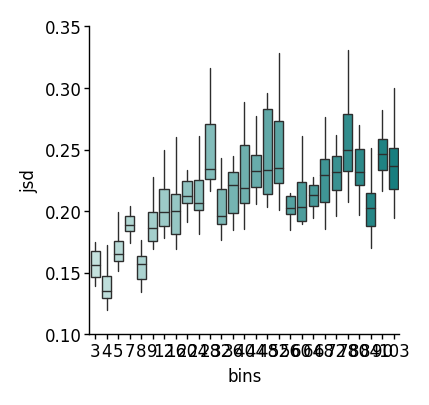

In [10]:
# plot jsd values values
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="bins", y="jsd",
             palette = phasec, dodge=True, showfliers=False, linewidth=0.5, showcaps=False)
ax.set_ylim(0.1,0.35)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'jsd_within_age_boxplot.pdf', bbox_inches='tight')

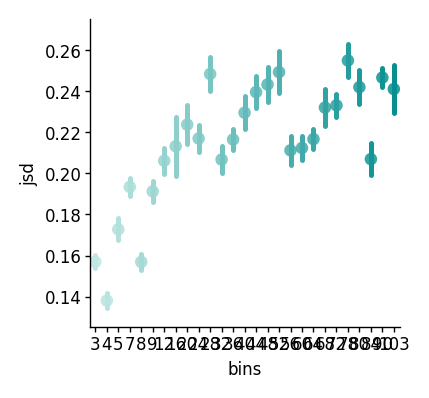

In [11]:
## show mean
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.pointplot(data=df, x="bins", y="jsd", 
            #notch= True,
            estimator='mean',
            #hue='age',
            errorbar = 'se',
            #palette = ['grey','#6a51a3'], 
            palette = phasec, 
            #dodge=True,
            #alpha=0.5,
            join=False)
ax.set_ylim(0.125,0.275)
plt.setp(ax.collections, alpha=.85)
plt.setp(ax.collections, edgecolor='none')
sns.despine()

c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'jsd_within_age_dotplot.pdf', bbox_inches='tight')

ValueError: Could not interpret input 'exp'

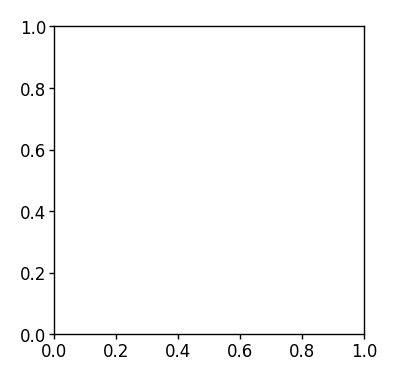

In [12]:
## show mean
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.pointplot(data=df, x="bins", y="jsd", hue='exp', 
            #notch= True,
            estimator='mean',
            #hue='age',
            errorbar = 'se',
            palette = ['grey','#6a51a3'], 
            #palette = cmm, 
            #dodge=True,
            #alpha=0.5,
            join=False)
ax.set_ylim(0.10,0.30)
plt.setp(ax.collections, alpha=.85)
plt.setp(ax.collections, edgecolor='none')
sns.despine()

c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig2"/ 'I_jsd_within_age_mean.pdf', bbox_inches='tight')

In [ ]:
## show means line

fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.lineplot(data=df, x="bins", y="jsd", hue='exp', 
            #notch= True,
            estimator='mean',
            errorbar = 'se',
            palette = ['grey','purple'], 
            #dodge=True,
            #alpha=0.5,
            #join=False,
            )
ax.set_ylim(0.10,0.25)
sns.despine()

c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig2"/ 'I_jsd_within_age_mean.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="exp", y="jsd", hue='exp', 
               notch=True,
               palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
#ax.set_ylim(0.0,0.15)
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'euc_within_age_compare.pdf', bbox_inches='tight')

In [ ]:
# plot jsd values values
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="bins", y="jsd", hue='exp', 
             palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
ax.set_ylim(0.1,0.25)
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "fig2"/ 'I_jsd_within_age_compare.pdf', bbox_inches='tight')